\tableofcontents


\pagebreak

# Introduction 

Exchage traded funds, ETF for short, are growing to be one of the largest new asset classes in the public markets today. In 2002 the total ETF assets under mamangement (AUM) was just $102 bb and in 2021, it had grown to $7,191 bb. This number is still growing. There are ETFs which just follow an index all the way to those which are essentially multi strategy hedge funds whose AUM grows through the ***create and redeem*** process. This process is not the focus of this paper but to quickly discuss this. Imagine an actively managed hedge fund has a portfolio of assets, they then are able to have "*buckets*" for creating or redeeming a share of said ETF. For the create side, an investor would approach a broker dealer to with the said "*create bucket*", just a portfolio of assets deemed by said ETF to be able to exchange for a share of the ETF. Then the broker dealer will initiate the exchange. The ETF will get the bucket of assets and the investor will get a share of the ETF. When the bucket in question is the "*redeem bucket*", this exchange of assets is just in reverse. This new ability for people to have access to either indexes, money managers, sectors, leverage by investing in a levered ETF, etc., along with the added liquidity these products provide is the main reason for their exponential growth. 

Since the ETF space is growing exponentially and allowing investors easier access to whole sectors, product types, strategies, funds, you name it, as well as the fact that these products are also tradeable in the market (regular buying and selling on an exchange), there comes a new opportunity. With a strong model for forecasting these products, a smart investor and/or trader now can take advantage of movements in areas once not able to take advantage of with the risks that come with trading derivatives. This is the goal of this paper. 

We will be conducting research into formualting an ARIMA model for Investment Grade (IG) Corporate Bond ETFs. The bond is not as liquid as the equity/derivative market but through ETFs, this liquidity issue is dampened. Thus, forming a model to be able to forecast price movements of an IG corporate bond ETF would allow a fixed income portfolio manager (PM) to not suffer from the lack of liquidity that trading singular bonds entails as well as avoiding the risk of derivatives that come with trading the accompanying index/s. For our purposes we will choose to model the BlackRock ETF "*iShares iBoxx $ Investment Grade Corporate Bond ETF*", which has the ticker symbol **LQD**. LQD's investment objective on [LQD's homepage](https://www.ishares.com/us/products/239566/LQD?cid=ppc:ishares_us:google:fund-names-priorities&gclid=CjwKCAiAs8acBhA1EiwAgRFdw4oE1UeE7tNO8c2Wdk4wXc1Bws2tNVdtapvDEiNLBcCoDFIBXoNhHhoCNIcQAvD_BwE&gclsrc=aw.ds):

> The iShares iBoxx $ Investment Grade Corporate Bond ETF seeks to track the investment results of an index composed of U.S. dollar-denominated, investment grade corporate bonds.

LQD is also one of if not the most popular IG corporate bond ETFs. We can measure this "*popularity*" by KPIs such as average volume and net assets. These stats can be found by going to ***yahoofinance.com*** and searching "*LQD*" in the search bar (or by clicking [here](https://finance.yahoo.com/quote/LQD?p=LQD&.tsrc=fin-srch)).

Our data, adjusted daily closing prices, was collected using the Python API **yfiance** ([documentation here](https://pypi.org/project/yfinance/)). This package is a webscraping package used to get historical data on any number of given names freely avaliable on [***yahoofinance.com***](https://finance.yahoo.com/). The reasoning behind using adjusted closing prices instead of closing prices is the dividend adjustment. If we were to model the actual price, forecasts will be off due to the LQD paying dividends. Since we are delaing with a publicly traded asset, the market is closed on weekends and some holidays. Thus, instead of using 365 days for a year, our data is actually 252 days per year on average. 

\pagebreak

In [157]:
"""Importing Packages"""
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import dates
from IPython.display import Markdown as md
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import datetime
from statsmodels.api import stats as sm
from loess import loess_1d
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from openpyxl import Workbook, load_workbook
from sklearn import linear_model
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from scipy.linalg import toeplitz
import math
import scipy.stats as stats
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.stl import STLForecast
from pmdarima.arima import auto_arima
import yfinance as yf
from IPython.display import Latex as Latex
from Converter import *
import arch.unitroot as unitroot
%matplotlib inline



# Data

We apply the general "*10-year*" rule to the amount of data we bring in (if the holding period of a strategy is a day or less, a backtest should be no less than 5 years). Our start and end dates for our data are 1/2/2017 and 1/3/2022 respectively. These are the first trading days of 2017 and 2022. 

In [158]:
'''importing the data'''
start = datetime.date(2017,1,2)
end = datetime.date(2022,1,4)
data = yf.download(['LQD'], start=start, end=end, progress=False)['Adj Close']
data = pd.DataFrame(data)
data.columns = ['LQD']

In [159]:
'''Graphing the time-series'''
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(12,6))
    ax = plt.axes()
    plt.plot(data, label = 'LQD')
    #plt.scatter(data.index, data['LQD'].values)
    plt.title('LQD\n {} - {}'.format(start.strftime('%m/%d/%Y'), (end-datetime.timedelta(days = 1)).strftime('%m/%d/%Y')))
    plt.xticks([data.loc[i].index.tolist()[0] for i in [str(j) for j in range(2017, 2023)]], [str(j) for j in range(2017, 2023)])
    plt.yticks([i for i in range(80, 140,5)])
    plt.ylabel('Price (USD)')
    plt.xlabel('Date')
    plt.legend()
    plt.savefig('LQDPrice.png', bbox_inches = 'tight')
    plt.close()
    #plt.show()



\begin{figure}[h]
    \centering
    \includegraphics{LQDPrice}
    \caption{time-series plot of LQD's price from 01/03/2012 - 01/03/2022}
    \label{fig:price1}
\end{figure}

# Evaluation

## Stationarity

To begin formualting our ARIMA model, we must first check for stationarity. We will use the   Augmented-Dickey Fuller test, and Phillips-Perron test, and the plotting of the Autocorrelation Function. 

### Augmented Dicky Fuller

In [160]:
adf = unitroot.ADF(data)
#print(adf.summary().as_latex()) I printed the latex and copied it into a markdown cell just added captions 

\begin{table}[h]
\begin{center}
\begin{tabular}{lr}
\toprule
Test Statistic     &             -0.164  \\
P-value            &              0.943  \\
Lags               &                 21  \\
\bottomrule
\end{tabular}
\caption{Augmented Dickey-Fuller Results}
\label{tab: ADF_before}
\end{center}
\end{table}

Trend: Constant \newline
 Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%) \newline
 Null Hypothesis: The process contains a unit root. \newline
 Alternative Hypothesis: The process is weakly stationary.

### Phillips-Perron

In [161]:
pp = unitroot.PhillipsPerron(data)
#print(pp.summary().as_latex())

\begin{table}[h]
\begin{center}
\begin{tabular}{lr}
\toprule
Test Statistic     &             -0.504  \\
P-value            &              0.891  \\
Lags               &                 27  \\
\bottomrule
\end{tabular}
\caption{Phillips-Perron Test (Z-tau)}
\label{tab: PP_before}
\end{center}
\end{table}

Trend: Constant \newline
 Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%) \newline
 Null Hypothesis: The process contains a unit root. \newline
 Alternative Hypothesis: The process is weakly stationary.

### Autocorrelation Function

In [162]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(12,6))
    ax = plt.axes()
    plot_acf(data, lags=25, ax=ax)
    plt.plot()
    plt.title('LQD')
    plt.ylabel('ACF')
    plt.xlabel('Lag')
    plt.yticks([i/100 for i in range(-100, 126, 25)])
    fig.savefig('ACF_before.png', bbox_inches = 'tight')
    plt.close()

    

\begin{figure}[h]
    \centering
    \includegraphics{ACF_before}
    \caption{the Autocorrelation function of LQD's price series}
    \label{fig:ACF1}
\end{figure}

## Conclusions

Let us first start with the ADF test in \ref{tab: ADF_before}. We can clearly see that with a P-value of $0.891$, that the process clearly contains a unit-root. This is also corroborated by the PP-test in \ref{tab: PP_before}. Referring back to the ACF plot in \ref{fig: ACF_before} we can clearly see basically no decay and a clearly trending process. With all three of our methods returning non-stationarity in both mean and variance we must look to perform appropriate transformation/s on our and re-evaluate out our new process.   

\pagebreak

# Transformations

It is common/best practice in the financial world to work with a log-returns when modeling price data. This is equivalent to a log-differencing tranformation. Where our transform is,
$$
y_{new}(t) = \log(\frac{y_t}{y_{t-1}})
$$
This transformation is advantageous due to their symmetry amongst other things. It should allow us to create a stationary mean and variance \cite{hudson_gregoriou_2010}. 


In [163]:
'''Performing the tranformation'''
data_tran = np.log(1+data.pct_change().dropna())


# Re-Evaluations

## Timeseries

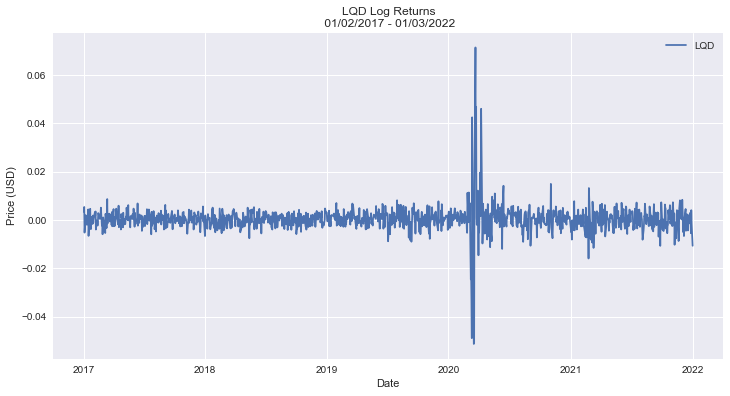

In [164]:
'''Graphing the time-series'''
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(12,6))
    ax = plt.axes()
    plt.plot(data_tran, label = 'LQD')
    #plt.scatter(data_tran.index, data_tran['LQD'].values)
    plt.title('LQD Log Returns\n {} - {}'.format(start.strftime('%m/%d/%Y'), (end-datetime.timedelta(days = 1)).strftime('%m/%d/%Y')))
    plt.xticks([data_tran.loc[i].index.tolist()[0] for i in [str(j) for j in range(2017, 2023)]], [str(j) for j in range(2017, 2023)])
    #plt.yticks([i for i in range(80, 140,5)])
    plt.ylabel('Price (USD)')
    plt.xlabel('Date')
    plt.legend()
    plt.savefig('LQDlogret.png', bbox_inches = 'tight')
    plt.show()
    plt.close()


\begin{figure}[h]
    \centering
    \includegraphics{LQDlogret}
    \caption{time-series plot of LQD's log-difference price-series 01/03/2012 - 01/03/2022}
    \label{fig:price2}
\end{figure}

\pagebreak

## Augmented Dicky Fuller

In [165]:
adf = unitroot.ADF(data_tran)
#print(adf.summary().as_latex()) #I printed the latex and copied it into a markdown cell just added captions 

\begin{table}[h]
\begin{center}
\begin{tabular}{lr}
\toprule
Test Statistic     &            -13.630  \\
P-value            &              0.000  \\
Lags               &                 20  \\
\bottomrule
\end{tabular}
\caption{Augmented Dickey-Fuller Results of LQD log-returns}
\label{tab: ADF_after}
\end{center}
\end{table}

Trend: Constant \newline
 Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%) \newline
 Null Hypothesis: The process contains a unit root. \newline
 Alternative Hypothesis: The process is weakly stationary.

## Phillips-Perron

In [166]:
pp = unitroot.PhillipsPerron(data_tran)
#print(pp.summary().as_latex())

\begin{table}[h]
\begin{center}
\begin{tabular}{lr}
\toprule
Test Statistic     &            -42.288  \\
P-value            &              0.000  \\
Lags               &                 27  \\
\bottomrule
\end{tabular}
\caption{Phillips-Perron Test (Z-tau) log-returns}
\label{tab: PP_after}
\end{center}
\end{table}

Trend: Constant \newline
 Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%) \newline
 Null Hypothesis: The process contains a unit root. \newline
 Alternative Hypothesis: The process is weakly stationary.

## Autocorrelation Function

In [167]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(12,6))
    ax = plt.axes()
    plot_acf(data_tran, lags=100, ax=ax)
    plt.plot()
    plt.title('LQD')
    plt.ylabel('ACF')
    plt.xlabel('Lag')
    plt.yticks([i/100 for i in range(-100, 126, 25)])
    fig.savefig('ACF_after.png', bbox_inches = 'tight')
    plt.close()

    

\begin{figure}[h]
    \centering
    \includegraphics{ACF_after}
    \caption{the Autocorrelation function of LQD's log-returns series}
    \label{fig:ACF2}
\end{figure}

## Conclusions



Based on the \ref{fig:price2} we can now see our transformed data has a stationary mean. Through p-values of \ref{tab:ADF_after} and \ref{tab:PP_after} we also see stationarity. Finally we can conclude our transformed data is stationary of the mean and variance with \ref{fig:ACF2} showing a sharp decay followed by a sinusoidal characteristic of stationarity.   

# X11 Decomposition

We will now decompose our log-returns data into it's seasonal, time-cycle, and irregular components. 

In [168]:
x11_in = data_tran.reset_index(drop=True)
X11 = STL(x11_in, period = 7, robust = True)
reg = X11.fit()
'''Graphing the time-series'''
with plt.style.context('seaborn'):
    fig = reg.plot()
    fig.savefig('X11.png')

    fig.clear()



<Figure size 576x396 with 0 Axes>

\begin{figure}[h]
    \centering
    \includegraphics{X11}
    \caption{LQD's log-returns decomposed into trend, seasonal, and irregular components graph.}
    \label{fig:Decomp}
\end{figure}

## Comments

We can clearly see that around 2020, the pandemic, the levels of the irregular components increased in volatility. This was due to the crash and subsiquent momentum IG Corporate bonds had during that era. 

Seasonality does not seem to be a key player in this even though we did set it 20 to account for monthly dividend payments. 

# Training and Testing

We first start by splitting our data set into training and testing sets in a $70\%-30\%$ split respectively.  

In [275]:
chopper = int(np.floor(len(data_tran)*.7))
train = data_tran.iloc[:chopper].asfreq('D', method = 'ffill', how = 'end')
test = data_tran.iloc[-(len(data_tran)-chopper+1):].asfreq('D', method = 'ffill', how = 'end')


# ARIMA model

We start by using the auto_arima() function to find the best one and two ARIMA models for the trainging set.

In [277]:
model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

#print(model_autoARIMA.summary().as_latex())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-9454.361, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-9775.286, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-9684.639, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-9773.291, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-9773.287, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-9774.413, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-9778.100, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-9465.528, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-9776.140, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-9776.112, Time=0.24 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-9707.584, Time=0.27 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-9774.230, Time=0.54 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 2.434 seconds


We can see from the printout of our function that the best two are ARIMA(1,0,0) and ARIMA(2,0,0). 

\begin{table}[h]
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}          &        y         & \textbf{  No. Observations:  } &    881      \\
\textbf{Model:}                  & SARIMAX(1, 0, 0) & \textbf{  Log Likelihood     } &  3272.907   \\
\textbf{Date:}                   & Fri, 09 Dec 2022 & \textbf{  AIC                } & -6541.813   \\
\textbf{Time:}                   &     20:11:45     & \textbf{  BIC                } & -6532.251   \\
\textbf{Sample:}                 &        0         & \textbf{  HQIC               } & -6538.157   \\
\textbf{}                        &       - 881      & \textbf{                     } &             \\
\textbf{Covariance Type:}        &       opg        & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{ar.L1}  &       0.2504  &        0.007     &    34.412  &         0.000        &        0.236    &        0.265     \\
\textbf{sigma2} &    3.472e-05  &     3.57e-07     &    97.137  &         0.000        &      3.4e-05    &     3.54e-05     \\
\bottomrule
\end{tabular}
\begin{tabular}{lclc}
\textbf{Ljung-Box (L1) (Q):}     &  0.01 & \textbf{  Jarque-Bera (JB):  } & 65987.94  \\
\textbf{Prob(Q):}                &  0.94 & \textbf{  Prob(JB):          } &   0.00    \\
\textbf{Heteroskedasticity (H):} & 11.62 & \textbf{  Skew:              } &   1.78    \\
\textbf{Prob(H) (two-sided):}    &  0.00 & \textbf{  Kurtosis:          } &  45.25    \\
\bottomrule
\end{tabular}
\caption{Best ARIMA Results, (1,0,0)}
\label{tab:ARIMA1}
\end{center}
\end{table}


Referring to \ref{tab:ARIMA1} we can see that the residuals appear to be correlated significantly.

In [287]:
model = ARIMA(train, order=(2,0,0))
fit = model.fit()
#for table in fit.summary().tables:
#    print(table.as_latex_tabular())

c:\Users\Chaz\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


\begin{table}[h]
\begin{center}
\begin{tabular}{lcccccc}
\toprule
                & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const}  &       0.0003  &        0.000     &     1.017  &         0.309        &       -0.000    &        0.001     \\
\textbf{ar.L1}  &       0.2523  &        0.008     &    30.077  &         0.000        &        0.236    &        0.269     \\
\textbf{ar.L2}  &      -0.0166  &        0.007     &    -2.418  &         0.016        &       -0.030    &       -0.003     \\
\textbf{sigma2} &    3.467e-05  &     4.08e-07     &    84.981  &         0.000        &     3.39e-05    &     3.55e-05     \\
\bottomrule
\end{tabular}
\end{center}
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Ljung-Box (L1) (Q):}     &  0.00 & \textbf{  Jarque-Bera (JB):  } & 63498.72  \\
\textbf{Prob(Q):}                &  0.99 & \textbf{  Prob(JB):          } &   0.00    \\
\textbf{Heteroskedasticity (H):} & 11.53 & \textbf{  Skew:              } &   1.69    \\
\textbf{Prob(H) (two-sided):}    &  0.00 & \textbf{  Kurtosis:          } &  44.45    \\
\bottomrule
\end{tabular}
\caption{ARIMA(2,0,0)}
\label{tab:ARIMA2}
\end{center}
\end{table}


We can clearly see again that these correlation between values is far worse.

In [ ]:
from sklearn.metrics import mean_squared_error
model = ARIMA(train, order=(2,0,0))
fit = model.fit()
pre = fit.forecast(547)
mse_2 = mean_squared_error(pre.values, test.values)

In [306]:
model = ARIMA(train, order=(1,0,0))
fit = model.fit()
pre = fit.forecast(547)
mse_1 = mean_squared_error(pre.values, test.values)
md("""MSE_1 = {} and the MSE_2 = {}""".format(mse_1, mse_2))

MSE_1 = 1.6503955948737755e-05 and the MSE_2 = 1.6503867015822117e-05

Thus on our test set predictions, we can clearly see that the ARIMA(2,0,0) did better yet not by much. They are practically the same. 

# EWMA 

In [311]:
fit1 = ExponentialSmoothing(train).fit()
pre = fit1.forecast(len(test))
mse_1 = mean_squared_error(pre.values, test.values)
md("""EWMA = {} and the MSE_2 = {}""".format(mse_1, mse_2))

EWMA = 2.2469002607829267e-05 and the MSE_2 = 1.6503867015822117e-05

Thus we can confidently say that our Arima model has a better forecasting error for this current test. 

\clearpage



\listoffigures
\listoftables
\appendix
\section{Code}


In [ ]:
"""Importing Packages"""
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import dates
from IPython.display import Markdown as md
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import datetime
from statsmodels.api import stats as sm
from loess import loess_1d
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from openpyxl import Workbook, load_workbook
from sklearn import linear_model
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from scipy.linalg import toeplitz
import math
import scipy.stats as stats
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.stl import STLForecast
from pmdarima.arima import auto_arima
import yfinance as yf
from IPython.display import Latex as Latex
from Converter import *
import arch.unitroot as unitroot
%matplotlib inline

'''importing the data'''
start = datetime.date(2017,1,2)
end = datetime.date(2022,1,4)
data = yf.download(['LQD'], start=start, end=end, progress=False)['Adj Close']
data = pd.DataFrame(data)
data.columns = ['LQD']

'''Graphing the time-series'''
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(12,6))
    ax = plt.axes()
    plt.plot(data, label = 'LQD')
    #plt.scatter(data.index, data['LQD'].values)
    plt.title('LQD\n {} - {}'.format(start.strftime('%m/%d/%Y'), (end-datetime.timedelta(days = 1)).strftime('%m/%d/%Y')))
    plt.xticks([data.loc[i].index.tolist()[0] for i in [str(j) for j in range(2017, 2023)]], [str(j) for j in range(2017, 2023)])
    plt.yticks([i for i in range(80, 140,5)])
    plt.ylabel('Price (USD)')
    plt.xlabel('Date')
    plt.legend()
    plt.savefig('LQDPrice.png', bbox_inches = 'tight')
    plt.close()
    #plt.show()

adf = unitroot.ADF(data)
#print(adf.summary().as_latex()) I printed the latex and copied it into a markdown cell just added captions 



pp = unitroot.PhillipsPerron(data)
#print(pp.summary().as_latex())


with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(12,6))
    ax = plt.axes()
    plot_acf(data, lags=25, ax=ax)
    plt.plot()
    plt.title('LQD')
    plt.ylabel('ACF')
    plt.xlabel('Lag')
    plt.yticks([i/100 for i in range(-100, 126, 25)])
    fig.savefig('ACF_before.png', bbox_inches = 'tight')
    plt.close()

'''Performing the tranformation'''
data_tran = np.log(1+data.pct_change().dropna())

'''Graphing the time-series'''
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(12,6))
    ax = plt.axes()
    plt.plot(data_tran, label = 'LQD')
    #plt.scatter(data_tran.index, data_tran['LQD'].values)
    plt.title('LQD Log Returns\n {} - {}'.format(start.strftime('%m/%d/%Y'), (end-datetime.timedelta(days = 1)).strftime('%m/%d/%Y')))
    plt.xticks([data_tran.loc[i].index.tolist()[0] for i in [str(j) for j in range(2017, 2023)]], [str(j) for j in range(2017, 2023)])
    #plt.yticks([i for i in range(80, 140,5)])
    plt.ylabel('Price (USD)')
    plt.xlabel('Date')
    plt.legend()
    plt.savefig('LQDlogret.png', bbox_inches = 'tight')
    plt.show()
    plt.close()

adf = unitroot.ADF(data_tran)
#print(adf.summary().as_latex()) #I printed the latex and copied it into a markdown cell just added captions 

pp = unitroot.PhillipsPerron(data_tran)
#print(pp.summary().as_latex())

with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(12,6))
    ax = plt.axes()
    plot_acf(data_tran, lags=100, ax=ax)
    plt.plot()
    plt.title('LQD')
    plt.ylabel('ACF')
    plt.xlabel('Lag')
    plt.yticks([i/100 for i in range(-100, 126, 25)])
    fig.savefig('ACF_after.png', bbox_inches = 'tight')
    plt.close()

x11_in = data_tran.reset_index(drop=True)
X11 = STL(x11_in, period = 7, robust = True)
reg = X11.fit()
'''Graphing the time-series'''
with plt.style.context('seaborn'):
    fig = reg.plot()
    fig.savefig('X11.png')

    fig.clear()

chopper = int(np.floor(len(data_tran)*.7))
train = data_tran.iloc[:chopper].asfreq('D', method = 'ffill', how = 'end')
test = data_tran.iloc[-(len(data_tran)-chopper+1):].asfreq('D', method = 'ffill', how = 'end')

model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

#print(model_autoARIMA.summary().as_latex())

model = ARIMA(train, order=(2,0,0))
fit = model.fit()
#for table in fit.summary().tables:
#    print(table.as_latex_tabular())

from sklearn.metrics import mean_squared_error
model = ARIMA(train, order=(2,0,0))
fit = model.fit()
pre = fit.forecast(547)
mse_2 = mean_squared_error(pre.values, test.values)
model = ARIMA(train, order=(1,0,0))
fit = model.fit()
pre = fit.forecast(547)
mse_1 = mean_squared_error(pre.values, test.values)
md("""MSE_1 = {} and the MSE_2 = {}""".format(mse_1, mse_2))

fit1 = ExponentialSmoothing(train).fit()
pre = fit1.forecast(len(test))
mse_1 = mean_squared_error(pre.values, test.values)
md("""EWMA = {} and the MSE_2 = {}""".format(mse_1, mse_2))



\bibliographystyle{plain} 
\bibliography{{refs}}

In [312]:
convert('Modeling Investment Grade Corporate Bond ETFs.ipynb')